# Ames Housing: Technical Modeling Report

**End-to-End Pipeline and Model Evaluation**

## Objective

This notebook runs the **complete Machine Learning pipeline** to predict house prices:

1. **Data loading and preprocessing** (without data leakage)  
2. **Training multiple models** with hyperparameter optimization (GridSearchCV)  
3. **Comparative evaluation** using MAE, RMSE, and R²  
4. **Error analysis** (residuals, predictions vs. actual values)  
5. **Interpretability** (feature importance)

<!-- All steps rely on functions from the modular pipeline developed in `src/`. -->

## Setup e Imports

In [5]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Add src to path (adjusted for your structure)
current_dir = os.getcwd()
src_path = os.path.join(current_dir, 'src')

if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import pipeline modules
from data_preprocessing import load_and_clean_data
from train_model import create_preprocessing_pipeline, train_multiple_models, save_model
from evaluate import (
    evaluate_multiple_models, 
    plot_predictions, 
    plot_residuals,
    plot_multiple_predictions,
    compare_models_plots,
    plot_feature_importance
)

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Modules imported successfully")

✓ Modules imported successfully


## 1. Data Loading and Preparation

We load the cleaned dataset and split it into features (X) and target (y).

In [6]:
# Load data
data_path = os.path.join('data', 'house_prices_records.csv')
df = load_and_clean_data(data_path)

# Split features and target
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

print(f"✓ Dataset loaded: {X.shape[0]} records, {X.shape[1]} features")
print(f"✓ Target variable: SalePrice (range ${y.min():,.0f} - ${y.max():,.0f})")

✓ Dataset loaded: 1460 records, 23 features
✓ Target variable: SalePrice (range $34,900 - $755,000)


## 2. Train/Test Split

We split the data into 80% training and 20% test sets with `random_state=22` for reproducibility.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22
)

print(f"✓ Train: {X_train.shape[0]} records")
print(f"✓ Test:  {X_test.shape[0]} records")

✓ Train: 1168 records
✓ Test:  292 records


## 3. Preprocessing Pipeline

We create a pipeline that:
- Automatically detects numerical and categorical variables  
- Applies `StandardScaler` to numerical features  
- Applies `OneHotEncoder` to categorical features (with `handle_unknown='ignore'`)  
- Is fitted **only on the training set** to avoid data leakage

In [8]:
# Create pipeline
preprocessing_pipeline = create_preprocessing_pipeline(X_train)

# Fit on train and transform both sets
X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
X_test_prepared = preprocessing_pipeline.transform(X_test)

print(f"✓ Pipeline created and applied")
print(f"✓ Dimensions after preprocessing:")
print(f"   Train: {X_train_prepared.shape}")
print(f"   Test:  {X_test_prepared.shape}")

✓ Pipeline created and applied
✓ Dimensions after preprocessing:
   Train: (1168, 38)
   Test:  (292, 38)


## 4. Model Training with GridSearchCV

We train **three regression models**, optimizing hyperparameters with **GridSearchCV** and 5-fold cross-validation:

1. **Random Forest Regressor**  
2. **Gradient Boosting Regressor**  
3. **Decision Tree Regressor**

Each model is evaluated on both train and test sets to detect overfitting.

In [9]:
# Model configuration and hyperparameter grids
models_config = [
    {
        "name": "RandomForest",
        "type": "random_forest",
        "param_grid": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    {
        "name": "GradientBoosting",
        "type": "gradient_boosting",
        "param_grid": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7]
        }
    },
    {
        "name": "DecisionTree",
        "type": "decision_tree",
        "param_grid": {
            "max_depth": [5, 10, 15, None],
            "min_samples_split": [2, 5, 10]
        }
    }
]

# Train models (this may take several minutes)
print("🔍 Training models with GridSearchCV (this may take some time)...\n")
trained_models = train_multiple_models(
    X_train_prepared, y_train, models_config, cv=5, scoring='r2'
)

🔍 Training models with GridSearchCV (this may take some time)...

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


### Best Hyperparameters Found

In [10]:
print("\n" + "="*70)
print("BEST HYPERPARAMETERS FOUND BY GRIDSEARCHCV")
print("="*70)

for model_name, model in trained_models.items():
    if hasattr(model, 'grid_search_info_'):
        info = model.grid_search_info_
        print(f"\n🔧 {model_name}:")
        print(f"   Best R² (CV): {info['best_score']:.4f}")
        print(f"   Params: {info['best_params']}")


BEST HYPERPARAMETERS FOUND BY GRIDSEARCHCV

🔧 RandomForest:
   Best R² (CV): 0.8570
   Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}

🔧 GradientBoosting:
   Best R² (CV): 0.8861
   Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

🔧 DecisionTree:
   Best R² (CV): 0.7462
   Params: {'max_depth': 15, 'min_samples_split': 10}


## 5. Model Evaluation and Comparison

We evaluate the models on the train and test sets to analyze:

- **MAE (Mean Absolute Error)**: Average error in dollars  
- **RMSE (Root Mean Squared Error)**: Penalizes large errors more strongly  
- **R² (Coefficient of Determination)**: Explained variance (0–1, higher is better)  
- **Overfitting Detection**: Difference between train and test R²

In [11]:
# Evaluate all the models
results_df = evaluate_multiple_models(
    trained_models, X_train_prepared, y_train, X_test_prepared, y_test
)


EVALUATION: RandomForest
TRAIN → MAE: 7,600.03 | RMSE: 13,102.82 | R²: 0.9730
TEST  → MAE: 16,886.10 | RMSE: 26,546.82 | R²: 0.8851

R² Difference: 0.0879
The model generalizes well

EVALUATION: GradientBoosting
TRAIN → MAE: 8,843.74 | RMSE: 11,763.94 | R²: 0.9782
TEST  → MAE: 16,205.16 | RMSE: 24,457.14 | R²: 0.9025

R² Difference: 0.0758
The model generalizes well

EVALUATION: DecisionTree
TRAIN → MAE: 9,167.51 | RMSE: 15,402.39 | R²: 0.9626
TEST  → MAE: 25,600.03 | RMSE: 42,001.72 | R²: 0.7123

R² Difference: 0.2503
X OVERFITTING detected

MODEL COMPARISON
          Modelo   Train_MAE  Train_R2   Train_RMSE     Test_MAE  Test_R2    Test_RMSE  Overfitting  R2_Diff
GradientBoosting 8843.741246  0.978208 11763.944645 16205.155889 0.902451 24457.143730        False 0.075757
    RandomForest 7600.030789  0.972965 13102.824181 16886.103134 0.885069 26546.819166        False 0.087896
    DecisionTree 9167.510968  0.962643 15402.386746 25600.034513 0.712297 42001.719622         True 0.2503

### Metric Interpretation

- **MAE**: Indicates the average error in dollars. An MAE of $20,000 means that, on average, predictions deviate by $20k from the true price.  
- **RMSE**: Penalizes large errors more heavily. Useful when large errors are especially critical.  
- **R²**: Measures what percentage of the price variability is explained by the model. R² = 0.85 means the model explains 85% of the variation.  
- **Overfitting**: If `R2_Diff > 0.10`, the model is memorizing the training data but not generalizing well to the test set.

### Visual Comparison of Metrics

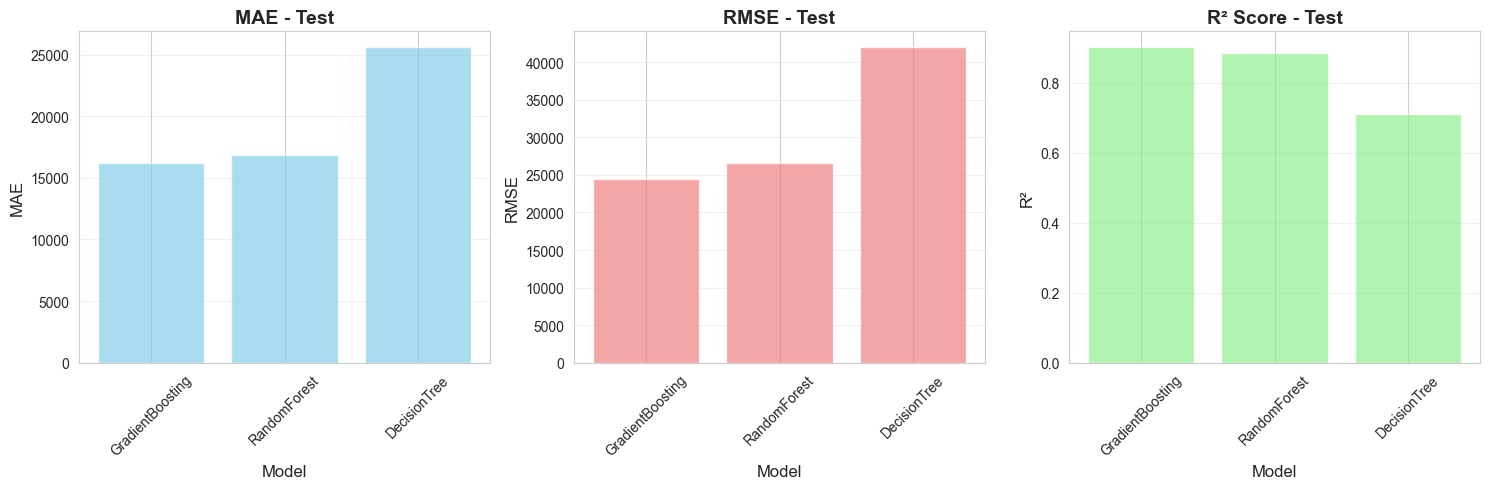

In [12]:
# Comparative metric plots
compare_models_plots(results_df, dataset_type="Test")

## 6. Best Model Analysis

We select the best model (highest R² on the test set) and analyze its predictions in detail.

In [13]:
# Identify the best model
best_model_name = results_df.iloc[0]['Modelo']
best_model = trained_models[best_model_name]

print(f"  Best Model: {best_model_name}")
print(f"   Test R²: {results_df.iloc[0]['Test_R2']:.4f}")
print(f"   Test MAE: ${results_df.iloc[0]['Test_MAE']:,.2f}")

  Best Model: GradientBoosting
   Test R²: 0.9025
   Test MAE: $16,205.16


### Predictions vs. Actual Values

This plot shows how close the predictions are to the actual values. Ideally, all points should lie on the red diagonal line.

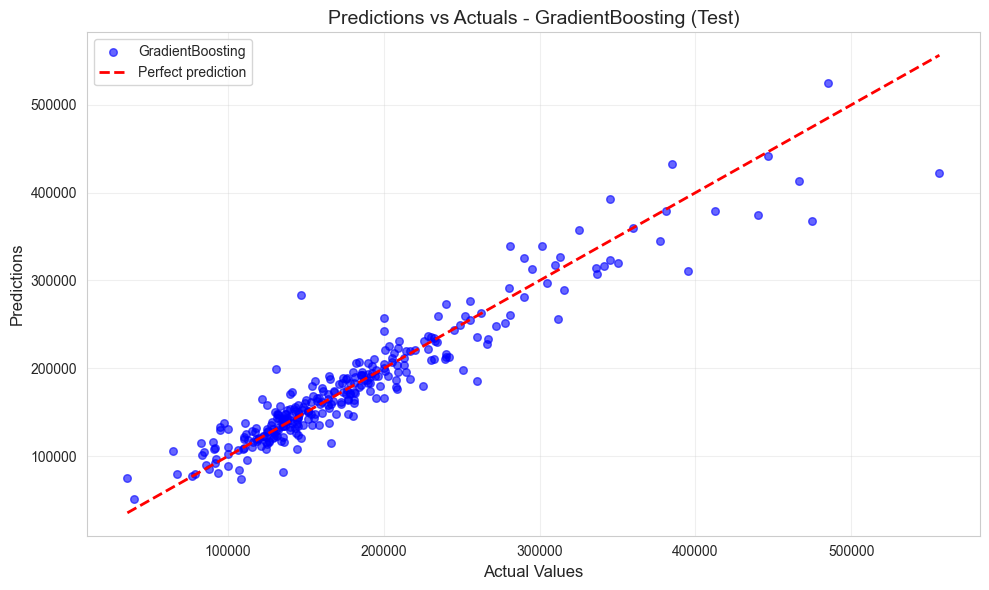

In [14]:
# Best model predictions
y_pred_best = best_model.predict(X_test_prepared)

# Plot predictions vs actual values
plot_predictions(y_test, y_pred_best, model_name=best_model_name, dataset_type="Test")

### Residual Analysis

Residuals (error = actual − prediction) should be randomly distributed around 0. Systematic patterns indicate that the model is not capturing all the relevant information.

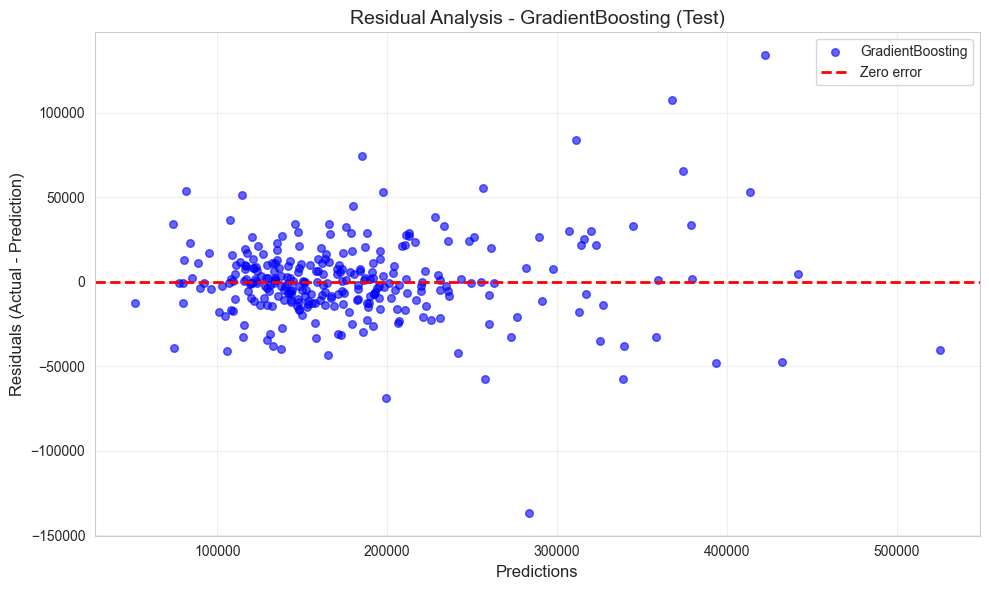

In [15]:
# Residuals plot
plot_residuals(y_test, y_pred_best, model_name=best_model_name, dataset_type="Test")

### Comparison of All Models (Predictions)

We visualize the predictions of all models side by side to compare their performance.

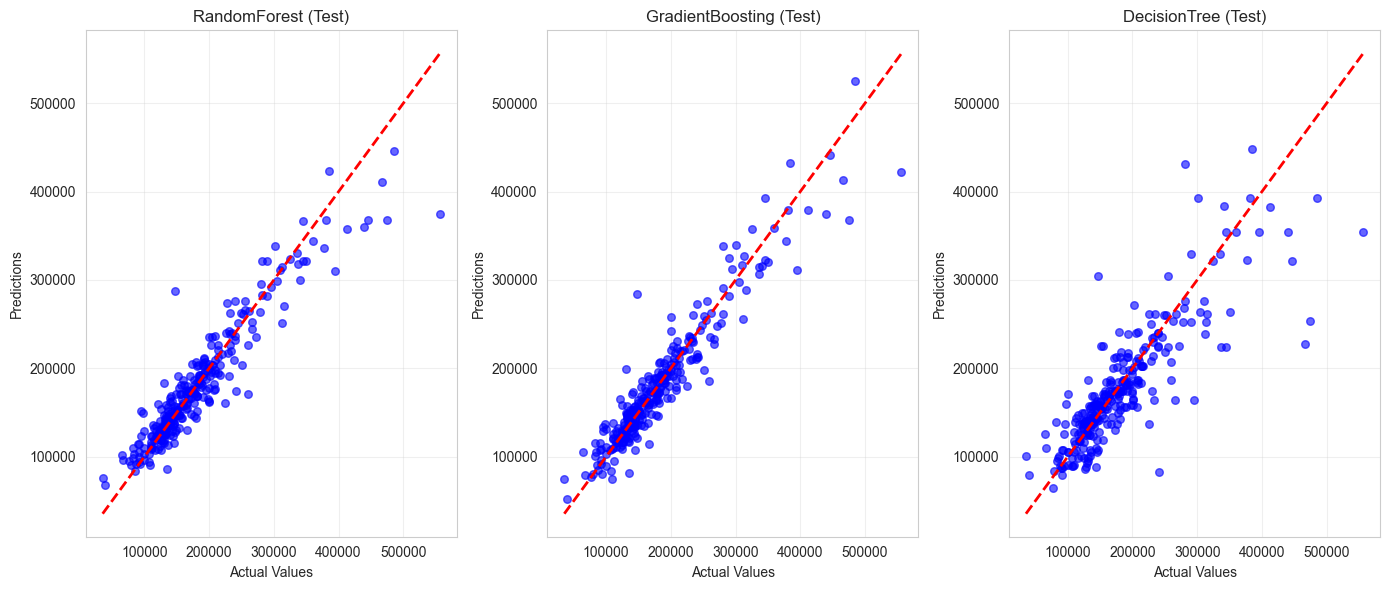

In [16]:
# Generate predictions for all models
predictions_dict = {
    name: model.predict(X_test_prepared)
    for name, model in trained_models.items()
}

# Comparative plot
plot_multiple_predictions(y_test, predictions_dict, dataset_type="Test")

### Feature Importance

Most influential variables in predicting the sale price.

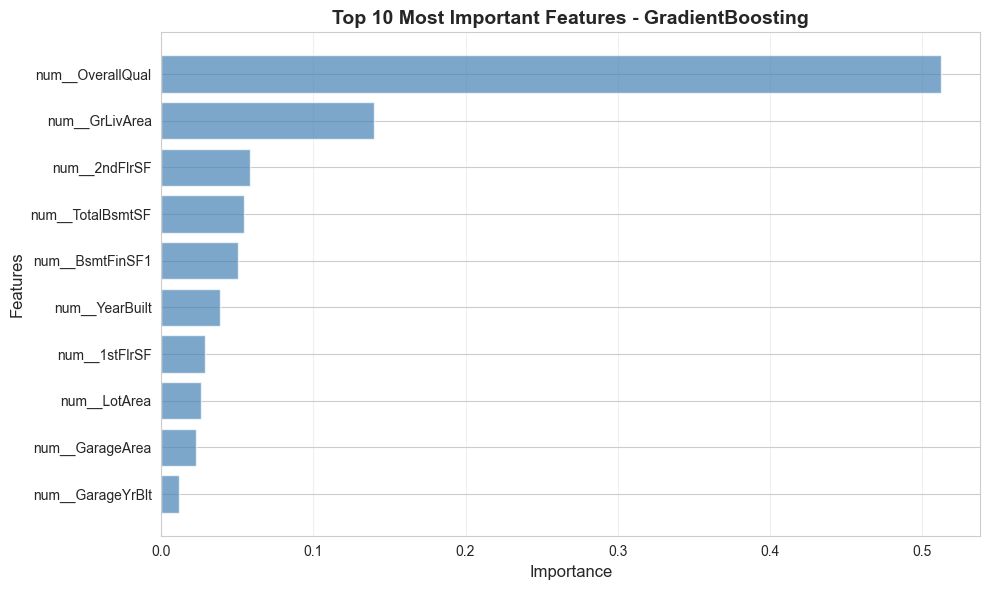

In [17]:
feature_names = (
                preprocessing_pipeline
                .named_steps["preprocessor"]
                .get_feature_names_out()
                .tolist()
            )
plot_feature_importance(
                best_model, feature_names, model_name=best_model_name)

## 7. Model Saving

We save the preprocessing pipeline and the best model for future use in production.

In [18]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save pipeline and best model
pipeline_path = '../models/pipeline.pkl'
best_model_path = '../models/best_model.pkl'

save_model(preprocessing_pipeline, pipeline_path)
save_model(best_model, best_model_path)

print(f"\n✓ Pipeline saved to: {pipeline_path}")
print(f"✓ Best model ({best_model_name}) saved to: {best_model_path}")

 Modelo guardado: ../models/pipeline.pkl
 Modelo guardado: ../models/best_model.pkl

✓ Pipeline saved to: ../models/pipeline.pkl
✓ Best model (GradientBoosting) saved to: ../models/best_model.pkl


## Conclusions and Next Steps

### Summary of Results

- **Best model**: The model with the best performance on unseen data (test set) is the one with the highest R² in the comparison table.  
- **Generalization**: Models with an R² difference < 0.10 between train and test are considered to generalize well.  
- **Practical interpretation**: MAE tells us how far off we are on average (in dollars). An MAE of $20,000 on a dataset with prices between $100k and $500k is reasonable.

### Best Practices Implemented

1. ✅ **No data leakage**: Preprocessing is fitted only on the training set  
2. ✅ **Cross-validation**: GridSearchCV with 5 folds for robust hyperparameter optimization  
3. ✅ **Multiple models**: Objective comparison of different algorithms  
4. ✅ **Error analysis**: Residuals and prediction plots  
5. ✅ **Reproducibility**: Fixed `random_state`, saved pipeline and model

---

Run `python main.py` to reproduce the entire pipeline from the terminal.